# MetricType and distances

https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances


Matthijs Douze https://gist.github.com/mdouze

# Notes on MetricType and distances
Faiss主要支持两种索引方法, `L2` 和 `inner product`. Others are supported by `IndexFlat`.

完整metrics列表, 参看: [here](https://github.com/facebookresearch/faiss/blob/master/Index.h#L44).

# METRIC_L2
Faiss使用`squared Euclidean (L2) distance`欧氏距离的平方, 避开了平方根. 但这仍然是一个单调（monotonic）的Euclidean distance, 因此，如果需要准确的距离，需要自己开方.

# METRIC_INNER_PRODUCT
这通常用于最大程度的内积搜索（This is typically used for maximum inner product search）. 除非向量被归一化（normalized），否则它本身不是cosine similarity(位于一个单位超球面的表面上; 参见下面see cosine similarity).

> cosine similarity 范围是[0,1]，只有归一化，才能落在这个范围。
>
> 也就是说，只有把向量归一化，内积和cosine，才能相近。

# How can I index vectors for cosine similarity?
如何用cosine similarity来索引向量:

- build an index with `METRIC_INNER_PRODUCT`
- normalize the vectors prior to adding them to the index (with `faiss.normalize_L2` in Python)
- normalize the vectors prior to searching them

> 用`METRIC_INNER_PRODUCT`参数来构建索引，然后再add和search前，需要先把向量归一化。

Note that this is equivalent to using an index with `METRIC_L2`, except that the distances are related by d_L2^2 = 2 - 2 * d_IP.

# Additional metrics
`IndexFlat`还支持其他的metrics, `GpuIndexFlat`稍后也会支持.

支持[METRIC_L1](https://en.wikipedia.org/wiki/Taxicab_geometry), [METRIC_Linf](https://en.wikipedia.org/wiki/Chebyshev_distance) and [METRIC_Lp](https://en.wikipedia.org/wiki/Lp_space). METRIC_Lp includes use of `Index::metric_arg` (C++) / `index.metric_arg` (Python) to set the power.

还支持[METRIC_Canberra](https://en.wikipedia.org/wiki/Canberra_distance), [METRIC_BrayCurtis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.braycurtis.html) and [METRIC_JensenShannon](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence). For Mahalanobis see below.

# How can I index vectors for Mahalanobis distance?
The [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) is equivalent to L2 distance in a transformed space. To transform to that space:

- compute the covariance matrix of the data
- multiply all vectors (query and database) by the inverse of the Cholesky decomposition of the covariance matrix.
- index in a METRIC_L2 index.
Example here: [mahalnobis_to_L2.ipynb](https://gist.github.com/mdouze/6cc12fa967e5d9911580ef633e559476)

(1000, 16)


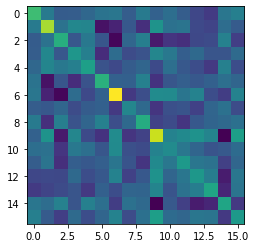

In [3]:
import numpy as np
import faiss
from matplotlib import pyplot

# generate data

# different variance in each dimension
x0 = faiss.randn((1000, 16)) * (1.2 ** -np.arange(16))

print(x0.shape)

# random rotation
R, _ = np.linalg.qr(faiss.randn((16, 16)))   
x = np.dot(x0, R).astype('float32')

# compute and visualize the covariance matrix
xc = x - x.mean(0)
cov = np.dot(xc.T, xc) / xc.shape[0]
_ = pyplot.imshow(cov)

How to whiten data with Faiss and compute Mahalnobis distance: [demo_whitening.ipynb](https://gist.github.com/mdouze/33fc39927c343c4ca003f1d8f5a412ef)

In [ ]:
import numpy as np
import faiss
from matplotlib import pyplot

# Generate a random matrix with Gaussian distribution
rs = np.random.RandomState(123)

d = 10
n = 10000

# Gaussian, identity covariance, mean 0
xnorm = rs.randn(n, d)

# Gaussian, general
x = xnorm @ rs.rand(d, d) + rs.rand(d)

# convert to float for Faiss
x = x.astype('float32')

# Train PCA with whitening
whiten = faiss.PCAMatrix(d, d, -0.5)
whiten.train(x)

# look at eigenvalues
faiss.vector_to_array(whiten.eigenvalues)

# apply whitening
xt = whiten.apply_py(x)

In [ ]:
# search on original vectors
index = faiss.IndexFlatL2(d)
index.add(x)
index.search(x[:3], 4)[1]

In [ ]:
# search on whitened vectors
index = faiss.IndexFlatL2(d)
index.add(xt)
index.search(xt[:3], 4)[1]

In [ ]:
# search in Gaussian space with identity covariance
index = faiss.IndexFlatL2(d)
index.add(xnorm.astype('float32'))
index.search(xnorm[:3].astype('float32'), 4)[1]

The results should be the same in the whitened space as with identity covariance.

Degenerate example

In [ ]:
# make rank-deficient matrix
M = rs.rand(d, d)
M[1] = M[0]

x = xnorm @ M + rs.rand(d)
x = x.astype('float32')
whiten = faiss.PCAMatrix(d, d, -0.5)
whiten.train(x)

print(faiss.vector_to_array(whiten.eigenvalues))
xt = whiten.apply_py(x)

In [ ]:
index = faiss.IndexFlatL2(d)
index.add(xt)
index.search(xt[:3], 4)[1]

Note that the results are now different. The last eigenvalue should be 0, but to numerical approximations it is +/- epsilon. If the sign happens to be negative, the result is even worse. In practice, it is best to restrict the output dimension to exclude too small eigenvalues: build the PCAMatrix with an output dimension smaller than d.

# How can I do max Inner Product search on indexes that support only L2?
Vectors can be transformed by adding one dimension so that max IP search becomes equivalent to L2 search. See http://ulrichpaquet.com/Papers/SpeedUp.pdf section 3 that transforms inner product computations into L2 distance computations. See an implementation here [demo_IP_to_L2.ipynb](https://gist.github.com/mdouze/e4bdb404dbd976c83fe447e529e5c9dc).

Note however that while mathematically equivalent, this may not interact well with quantization.

In [ ]:
import numpy as np
import faiss

In [ ]:
nq = 100
nb = 1000
d = 32

xq = faiss.randn((nq, d))
xb = faiss.randn((nb, d))

In [ ]:
# reference IP search
k = 10
index = faiss.IndexFlatIP(d)
index.add(xb)
Dref, Iref = index.search(xq, k)

In [ ]:
# see http://ulrichpaquet.com/Papers/SpeedUp.pdf theorem 5

def get_phi(xb): 
    return (xb ** 2).sum(1).max()

def augment_xb(xb, phi=None): 
    norms = (xb ** 2).sum(1)
    if phi is None: 
        phi = norms.max()
    extracol = np.sqrt(phi - norms)
    return np.hstack((xb, extracol.reshape(-1, 1)))

def augment_xq(xq): 
    extracol = np.zeros(len(xq), dtype='float32')
    return np.hstack((xq, extracol.reshape(-1, 1)))

In [ ]:
# reference IP search
k = 10
index = faiss.IndexFlatL2(d + 1)
index.add(augment_xb(xb))
D, I = index.search(augment_xq(xq), k)

In [ ]:
np.all(I == Iref)